# IBM HR ANALYTICS - EMPLOYEE ATTRITION & PERFORMANCE PREDICTION

### Part 4 & 5: Feature Engineering + Machine Learning Models

In [19]:
# Install dependencies
!pip install imbalanced-learn xgboost --quiet

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Load Dataset

In [20]:
df = pd.read_csv("/content/hr_analytics_preprocessed.csv")  # change path if needed

print("✅ Dataset Loaded Successfully!\n")
print(df.head())
print("\n📊 Dataset Shape:", df.shape)
print("\n🔍 Missing Values:\n", df.isnull().sum())


✅ Dataset Loaded Successfully!

   Age  BusinessTravel  DailyRate  Department  DistanceFromHome  Education  \
0   41               2       1102           2                 1          2   
1   49               1        279           1                 8          1   
2   37               2       1373           1                 2          2   
3   33               1       1392           1                 3          4   
4   27               2        591           1                 2          1   

   EducationField  EnvironmentSatisfaction  Gender  HourlyRate  ...  \
0               1                        2       0          94  ...   
1               1                        3       1          61  ...   
2               4                        4       1          92  ...   
3               1                        4       0          56  ...   
4               3                        1       1          40  ...   

   RelationshipSatisfaction  StockOptionLevel  TotalWorkingYears  \
0   

# Basic Data Visualizations

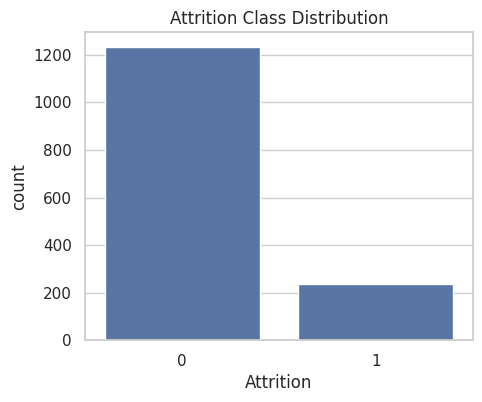

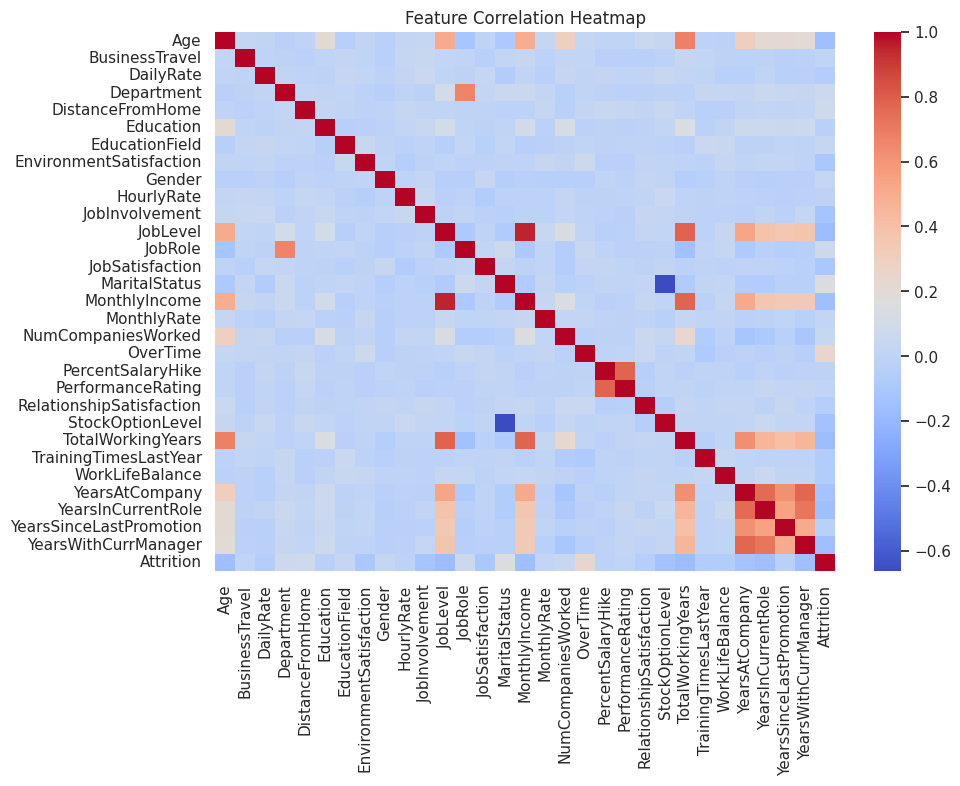

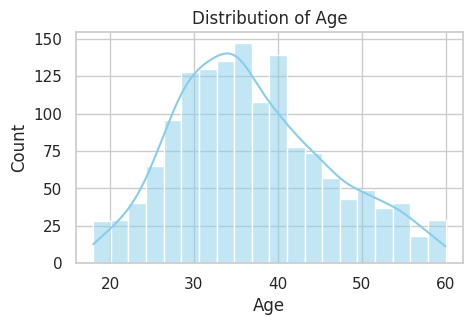

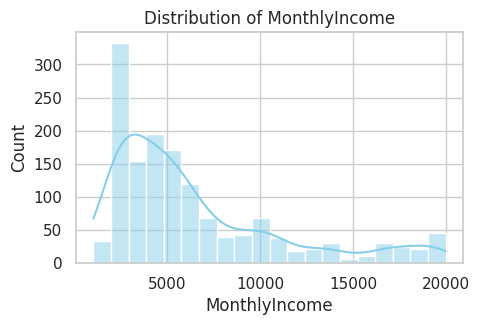

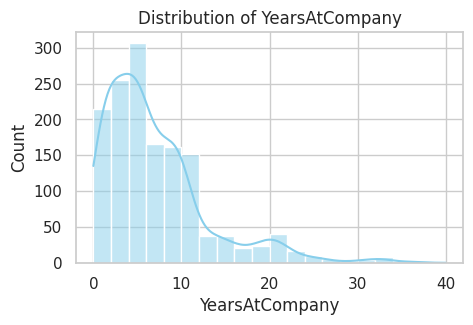

In [21]:
plt.figure(figsize=(5,4))
sns.countplot(x="Attrition", data=df)
plt.title("Attrition Class Distribution")
plt.show()

# Correlation heatmap (numerical columns only)
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Example distribution of a few key features
key_features = ["Age", "MonthlyIncome", "YearsAtCompany"]
for feature in key_features:
    plt.figure(figsize=(5,3))
    sns.histplot(df[feature], kde=True, bins=20, color='skyblue')
    plt.title(f"Distribution of {feature}")
    plt.show()


# Prepare Data

In [22]:
target = 'Attrition'
if target not in df.columns:
    raise ValueError("❌ 'Attrition' column not found!")

X = df.drop(columns=[target])
y = df[target].map({'Yes': 1, 'No': 0}) if df[target].dtype == 'object' else df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Balance Classes using SMOTE

In [23]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("\n✅ After SMOTE Balancing:", y_train_bal.value_counts().to_dict())



✅ After SMOTE Balancing: {0: 986, 1: 986}


# Scale Data

In [24]:
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test = scaler.transform(X_test)


# Train Multiple Models

In [25]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

results = {}
roc_auc_scores = {}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[name] = acc
    roc_auc_scores[name] = roc_auc

    print(f"\n📊 {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))



📊 Logistic Regression
Accuracy: 0.7993
ROC-AUC: 0.7182
Confusion Matrix:
 [[211  36]
 [ 23  24]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.88       247
           1       0.40      0.51      0.45        47

    accuracy                           0.80       294
   macro avg       0.65      0.68      0.66       294
weighted avg       0.82      0.80      0.81       294


📊 Random Forest
Accuracy: 0.7993
ROC-AUC: 0.7346
Confusion Matrix:
 [[222  25]
 [ 34  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88       247
           1       0.34      0.28      0.31        47

    accuracy                           0.80       294
   macro avg       0.60      0.59      0.59       294
weighted avg       0.78      0.80      0.79       294


📊 XGBoost
Accuracy: 0.8265
ROC-AUC: 0.7411
Confusion Matrix:
 [[227  20]
 [ 31  16]]
Classification Report:

# Model Comparison - Accuracy Bar Graph

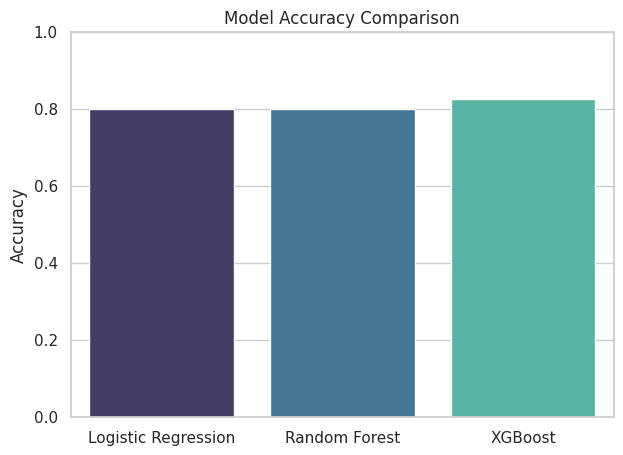

In [26]:
plt.figure(figsize=(7,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="mako")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


# ROC Curve Comparison

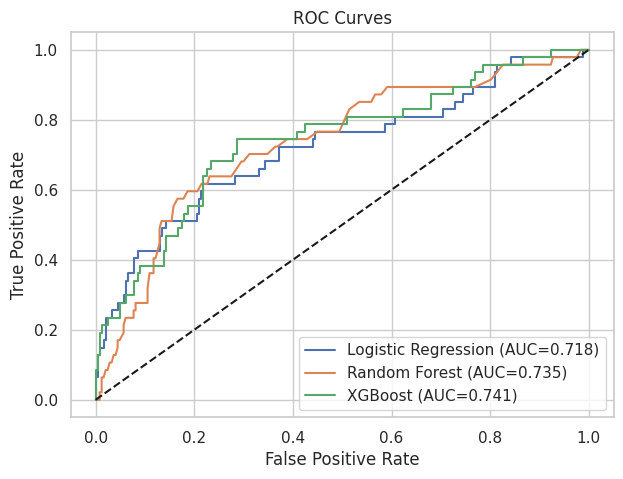

In [27]:
plt.figure(figsize=(7,5))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_scores[name]:.3f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


# Feature Importance (Random Forest & XGBoost)

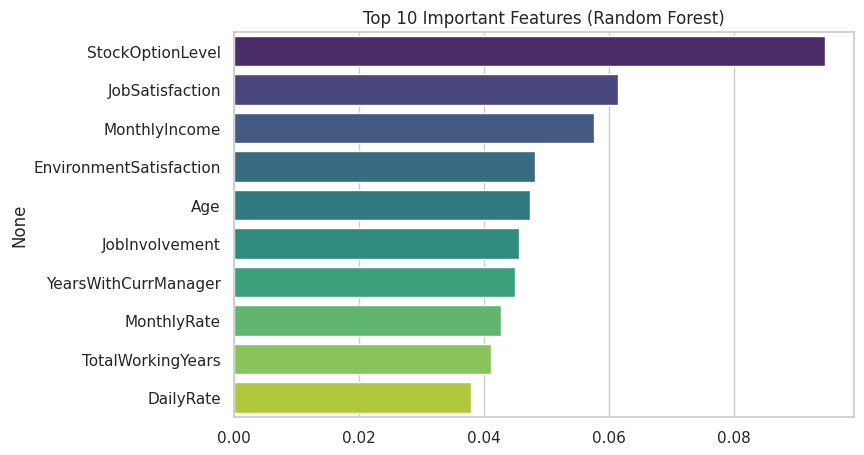

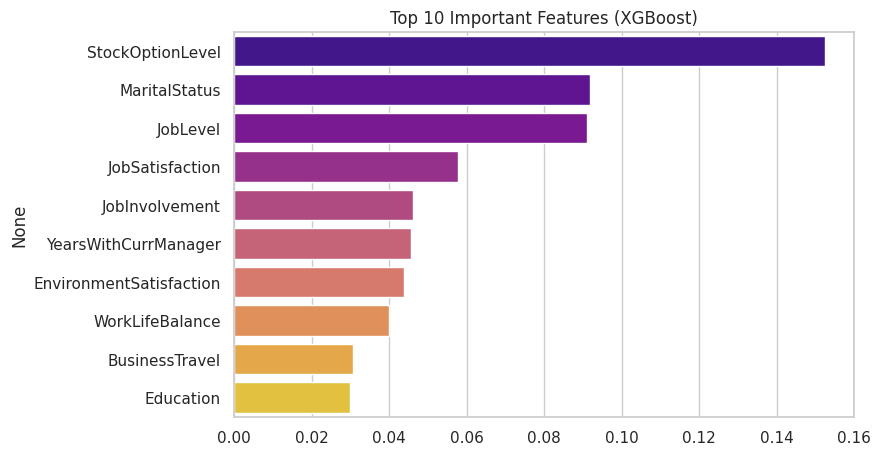


✅ All analyses completed successfully!


In [28]:
rf = models["Random Forest"]
xgb = models["XGBoost"]

# Random Forest Feature Importance
plt.figure(figsize=(8,5))
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
sns.barplot(x=imp.values, y=imp.index, palette="viridis")
plt.title("Top 10 Important Features (Random Forest)")
plt.show()

# XGBoost Feature Importance
plt.figure(figsize=(8,5))
imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
sns.barplot(x=imp.values, y=imp.index, palette="plasma")
plt.title("Top 10 Important Features (XGBoost)")
plt.show()

print("\n✅ All analyses completed successfully!")
